
# Vision-LLM for Compound Emotion Recognition
Ce notebook implémente le pipeline complet Vision-LLM pour RAF-CE:
 - Chargement de BLIP-2, LLaVA, Qwen-VL
 - Fine-tuning avec LoRA/QLoRA
 - Évaluation et benchmarking
 - Comparaison avec baselines

In [2]:
# %% 1. INSTALLATION DES DÉPENDANCES
print("📦 Installation des dépendances Vision-LLM...")
!pip install -q transformers accelerate peft bitsandbytes
!pip install -q sentencepiece protobuf
!pip install -q torch torchvision --upgrade


📦 Installation des dépendances Vision-LLM...


In [3]:
# %% 2. IMPORTS
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    Blip2Processor, Blip2ForConditionalGeneration,
    LlavaNextProcessor, LlavaNextForConditionalGeneration,
    BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import json
import time
from typing import Dict, List, Optional
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')


In [4]:
# %% 3. MONTAGE DU DRIVE ET VÉRIFICATION
print("\n" + "="*80)
print("📂 PHASE 2: CONNEXION AU DRIVE")
print("="*80)

# Monter le Drive
drive.mount('/content/drive')

# Définir les chemins
SHARED_DRIVE = '/content/drive/Shareddrives/Vision-LLM-Project-Team'


📂 PHASE 2: CONNEXION AU DRIVE
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Vérifier que le dossier existe
if os.path.exists(SHARED_DRIVE):
    print(f"✅ Drive partagé trouvé: {SHARED_DRIVE}")

    # Lister les dossiers
    folders = os.listdir(SHARED_DRIVE)
    print(f"\n📁 Dossiers disponibles: {folders}")

    # Vérifier les dossiers clés
    for folder in ['dataset', 'models', 'notebooks', 'results', 'src']:
        folder_path = os.path.join(SHARED_DRIVE, folder)
        if os.path.exists(folder_path):
            print(f"  ✓ {folder}/")
        else:
            print(f"  ⚠️ {folder}/ - MANQUANT (sera créé)")
            os.makedirs(folder_path, exist_ok=True)
else:
    print(f"❌ ERREUR: Le dossier {SHARED_DRIVE} n'existe pas!")
    print("Vérifiez le nom exact du Drive partagé.")

✅ Drive partagé trouvé: /content/drive/Shareddrives/Vision-LLM-Project-Team

📁 Dossiers disponibles: ['dataset', 'notebooks', 'models', 'results', 'src']
  ✓ dataset/
  ✓ models/
  ✓ notebooks/
  ✓ results/
  ✓ src/


In [6]:
# %% EXTRACTION DU DATASET - VERSION CORRIGÉE
print("\n" + "="*80)
print("📦 PHASE 1.5: EXTRACTION DU DATASET")
print("="*80)

import zipfile
from pathlib import Path

# Chemins
zip_path = "/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/aligned.zip"
extract_to = "/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/aligned"

# Vérifier si déjà extrait
if Path(extract_to).exists() and len(list(Path(extract_to).glob("*.jpg"))) > 0:
    print(f"✅ Dataset déjà extrait: {len(list(Path(extract_to).glob('*.jpg')))} images trouvées")
else:
    print("🔓 Extraction du fichier ZIP...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✅ Extraction terminée dans: {extract_to}")

# ✅ CORRECTION ICI : Convertir en Path
image_dir = Path("/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/aligned/aligned")

# Chercher automatiquement le bon dossier
if not image_dir.exists() or len(list(image_dir.glob("*.jpg"))) == 0:
    print("\n🔍 Recherche automatique du dossier des images...")
    base_path = Path("/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/aligned")

    for root, dirs, files in os.walk(base_path):
        jpg_files = [f for f in files if f.endswith('.jpg')]
        if len(jpg_files) > 10:
            image_dir = Path(root)
            print(f"✅ Images trouvées dans: {image_dir}")
            break

# Vérifier le contenu
sample_images = list(image_dir.glob("*.jpg"))[:5]
total_images = len(list(image_dir.glob("*.jpg")))

print(f"\n📂 Nombre total d'images: {total_images}")
print(f"📷 Exemples de noms de fichiers:")
for img in sample_images:
    print(f"   - {img.name}")

# Sauvegarder le chemin pour la suite
FINAL_IMG_DIR = image_dir
print(f"\n✅ Chemin final confirmé: {FINAL_IMG_DIR}")


📦 PHASE 1.5: EXTRACTION DU DATASET
🔓 Extraction du fichier ZIP...
✅ Extraction terminée dans: /content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/aligned

📂 Nombre total d'images: 4908
📷 Exemples de noms de fichiers:
   - 2122_aligned.jpg
   - 2123_aligned.jpg
   - 2120_aligned.jpg
   - 2114_aligned.jpg
   - 2127_aligned.jpg

✅ Chemin final confirmé: /content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/aligned/aligned


In [7]:
# %% COPIE DES IMAGES VERS /content (LOCAL COLAB)
import shutil
from pathlib import Path

print("\n" + "="*80)
print("📦 PHASE 1.7: COPIE DES IMAGES EN LOCAL")
print("="*80)

# Chemins
source_dir = Path("/content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/aligned/aligned")
dest_dir = Path("/content/raf-ce-images/aligned")

# Créer le dossier destination
dest_dir.mkdir(parents=True, exist_ok=True)

# Vérifier la source
if not source_dir.exists():
    print(f"❌ ERREUR: Source non trouvée {source_dir}")
else:
    # Compter les images
    images = list(source_dir.glob("*.jpg"))
    print(f"📊 {len(images)} images trouvées dans le Drive")

    # Copier (uniquement si pas déjà fait)
    if len(list(dest_dir.glob("*.jpg"))) < 100:
        print("⏳ Copie en cours (cela peut prendre 2-3 minutes)...")
        shutil.copytree(source_dir, dest_dir / "aligned", dirs_exist_ok=True)
        print(f"✅ Images copiées vers {dest_dir / 'aligned'}")
    else:
        print("✅ Images déjà présentes en local")

    # Vérification finale
    local_images = list((dest_dir / "aligned").glob("*.jpg"))
    print(f"✅ {len(local_images)} images disponibles localement")
    print(f"📂 Chemin final: {dest_dir / 'aligned'}")


📦 PHASE 1.7: COPIE DES IMAGES EN LOCAL
📊 4908 images trouvées dans le Drive
⏳ Copie en cours (cela peut prendre 2-3 minutes)...
✅ Images copiées vers /content/raf-ce-images/aligned/aligned
✅ 4908 images disponibles localement
📂 Chemin final: /content/raf-ce-images/aligned/aligned


In [8]:
# %% 4. CONFIGURATION GLOBALE - VERSION CORRIGÉE
print("\n" + "="*80)
print("⚙️ PHASE 3: CONFIGURATION")
print("="*80)

class Config:
    """Configuration centralisée du projet"""

    # === PATHS ===
    SHARED_DRIVE = Path(SHARED_DRIVE)

    # Données - ⚠️ UTILISER LE CHEMIN LOCAL COLAB (plus rapide)
    DATA_DIR = Path('/content/raf-ce-images/aligned/aligned')  # ← Correct maintenant

    LABEL_FILE = SHARED_DRIVE / 'dataset/raw/RAFCE_emolabel.txt'
    PARTITION_FILE = SHARED_DRIVE / 'dataset/raw/RAFCE_partition.txt'
    CLASS_WEIGHTS = SHARED_DRIVE / 'dataset/class_weights.pt'
    LABEL_MAPPING = SHARED_DRIVE / 'dataset/label_mapping.json'

    # Output
    MODELS_DIR = SHARED_DRIVE / 'models'
    RESULTS_DIR = SHARED_DRIVE / 'results'
    CHECKPOINTS_DIR = MODELS_DIR / 'checkpoints'

    # Créer les dossiers
    for dir_path in [MODELS_DIR, RESULTS_DIR, CHECKPOINTS_DIR]:
        dir_path.mkdir(parents=True, exist_ok=True)

    # Vérifier que les images existent
    if not DATA_DIR.exists() or len(list(DATA_DIR.glob("*.jpg"))) == 0:
        print(f"⚠️ ATTENTION: Aucune image dans {DATA_DIR}")
        print("➡️ Exécutez la cellule de copie ci-dessus")
    else:
        print(f"✅ {len(list(DATA_DIR.glob('*.jpg')))} images trouvées!")

    # === MODEL SETTINGS ===
    MODEL_NAME = "Salesforce/blip2-opt-2.7b"
    MODEL_TYPE = "blip2"

    # Quantization
    USE_4BIT = True

    # LoRA
    USE_LORA = True
    LORA_R = 8
    LORA_ALPHA = 16
    LORA_DROPOUT = 0.05

    # === TRAINING ===
    BATCH_SIZE = 2
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 3
    GRADIENT_ACCUMULATION_STEPS = 4

    # === INFERENCE ===
    MAX_NEW_TOKENS = 128
    TEMPERATURE = 0.7
    TOP_P = 0.9

    # === RAF-CE CLASSES ===
    CLASSES = {
        0: "happily surprised", 1: "happily disgusted", 2: "sadly fearful",
        3: "sadly angry", 4: "sadly surprised", 5: "sadly disgusted",
        6: "fearfully angry", 7: "fearfully surprised", 8: "fearfully disgusted",
        9: "angrily surprised", 10: "angrily disgusted", 11: "disgustedly surprised",
        12: "happily fearful", 13: "happily sad"
    }
    NUM_CLASSES = len(CLASSES)

    # === DEVICE ===
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Vérification finale
print(f"\n✅ Configuration chargée")
print(f"📍 Dossier des images: {Config.DATA_DIR}")
print(f"📊 Nombre d'images: {len(list(Config.DATA_DIR.glob('*.jpg')))}")
print(f"📍 Device: {Config.DEVICE}")

if Config.DEVICE == 'cuda':
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"💾 VRAM: {gpu_mem:.2f} GB")


⚙️ PHASE 3: CONFIGURATION
✅ 4908 images trouvées!

✅ Configuration chargée
📍 Dossier des images: /content/raf-ce-images/aligned/aligned
📊 Nombre d'images: 4908
📍 Device: cuda
🎮 GPU: Tesla T4
💾 VRAM: 15.83 GB


In [9]:
# Afficher les infos
print(f"📍 Device: {Config.DEVICE}")
if Config.DEVICE == 'cuda':
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"💾 VRAM: {gpu_mem:.2f} GB")
    print(f"✓ {'Suffisant' if gpu_mem >= 15 else 'Limité - Utiliser 4-bit quant'}")
else:
    print("⚠️ ATTENTION: Pas de GPU détecté!")

print(f"\n📁 Dossiers de sortie:")
print(f"  - Modèles: {Config.MODELS_DIR}")
print(f"  - Résultats: {Config.RESULTS_DIR}")

📍 Device: cuda
🎮 GPU: Tesla T4
💾 VRAM: 15.83 GB
✓ Suffisant

📁 Dossiers de sortie:
  - Modèles: /content/drive/Shareddrives/Vision-LLM-Project-Team/models
  - Résultats: /content/drive/Shareddrives/Vision-LLM-Project-Team/results


In [10]:
# %% 5. PROMPT TEMPLATES
print("\n" + "="*80)
print("💡 PHASE 4: PROMPT ENGINEERING")
print("="*80)

PROMPT_CLASSIFICATION = f"""Analyze this facial expression carefully. The person is showing a compound emotion (a mix of two basic emotions).

Possible compound emotions: {', '.join(Config.CLASSES.values())}

Identify the compound emotion and explain which facial cues support your answer:
- Eyebrows: raised, lowered, or furrowed?
- Eyes: wide, narrow, tense, or relaxed?
- Mouth: corners up or down, open or closed?
- Overall muscle tension

Response format:
Emotion: [one compound emotion from the list above]
Explanation: [describe the specific facial cues you observe]"""

print("✅ Prompt template créé")
print(f"\nPrompt length: {len(PROMPT_CLASSIFICATION)} caractères")


💡 PHASE 4: PROMPT ENGINEERING
✅ Prompt template créé

Prompt length: 757 caractères


In [11]:
# %% 6. DATASET VISION-LLM
print("\n" + "="*80)
print("📊 PHASE 5: CRÉATION DU DATASET")
print("="*80)

class RAFCEVisionLLMDataset(Dataset):
    """Dataset pour Vision-LLM avec prompts"""

    def __init__(self, img_dir, label_file, partition_file, processor,
                 split='test', prompt=None):
        self.img_dir = Path(img_dir)
        self.processor = processor
        self.prompt = prompt if prompt else PROMPT_CLASSIFICATION

        # Charger les données
        print(f"  Chargement des labels depuis {label_file}...")
        df_labels = pd.read_csv(label_file, sep=' ', header=None, names=['image', 'label'])
        df_partition = pd.read_csv(partition_file, sep=' ', header=None, names=['image', 'partition'])
        df = pd.merge(df_labels, df_partition, on='image')

        # Filtrer selon le split
        split_map = {'train': 0, 'val': 2, 'test': 1}
        self.data = df[df['partition'] == split_map[split]].reset_index(drop=True)

        print(f"  ✓ {split.upper()} set: {len(self)} images")

        # Afficher la distribution
        label_counts = self.data['label'].value_counts().sort_index()
        print(f"  Distribution des classes:")
        for label_id in range(Config.NUM_CLASSES):
            count = label_counts.get(label_id, 0)
            emotion = Config.CLASSES[label_id]
            print(f"    {label_id:2d}. {emotion:25s} : {count:3d} images")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['image']
        label = int(row['label'])

        # Chercher l'image (gérer différents noms possibles)
        possible_names = [
            img_name,
            img_name + '.jpg',
            img_name.replace('.jpg', '') + '_aligned.jpg'
        ]

        img_path = None
        for name in possible_names:
            temp_path = self.img_dir / name
            if temp_path.exists():
                img_path = temp_path
                break

        # Charger l'image
        if img_path and img_path.exists():
            try:
                image = Image.open(img_path).convert('RGB')
            except Exception as e:
                print(f"⚠️ Erreur chargement {img_name}: {e}")
                image = Image.new('RGB', (224, 224), color='gray')
        else:
            print(f"⚠️ Image non trouvée: {img_name}")
            image = Image.new('RGB', (224, 224), color='gray')

        label_text = Config.CLASSES[label]

        # Target pour le training
        target = f"Emotion: {label_text}\nExplanation: This facial expression clearly shows {label_text} with corresponding facial muscle movements and Action Units."

        return {
            'image': image,
            'label': label,
            'label_text': label_text,
            'prompt': self.prompt,
            'target': target,
            'image_path': str(img_path) if img_path else 'unknown'
        }


📊 PHASE 5: CRÉATION DU DATASET


In [12]:
# Test de chargement (sera utilisé plus tard)
print("\n✅ Classe Dataset créée et prête!")

# %% 7. CHARGEMENT DU MODÈLE BLIP-2
print("\n" + "="*80)
print("🤖 PHASE 6: CHARGEMENT DU MODÈLE BLIP-2")
print("="*80)

def load_blip2_model(use_4bit=True, use_lora=False):
    """Charge BLIP-2 avec quantization et optionnellement LoRA"""

    print(f"\n🔄 Chargement de {Config.MODEL_NAME}...")
    print(f"  - Quantization 4-bit: {'✓' if use_4bit else '✗'}")
    print(f"  - LoRA: {'✓' if use_lora else '✗'}")

    # Configuration de quantization
    quant_config = None
    if use_4bit:
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        )
        print("  🔧 Configuration 4-bit créée")

    # Charger le processor
    print("  📥 Chargement du processor...")
    processor = Blip2Processor.from_pretrained(Config.MODEL_NAME)

    # Charger le modèle
    print("  📥 Chargement du modèle (cela peut prendre 1-2 minutes)...")
    model = Blip2ForConditionalGeneration.from_pretrained(
        Config.MODEL_NAME,
        quantization_config=quant_config,
        device_map="auto",
        torch_dtype=torch.float16
    )

    print(f"  ✅ Modèle chargé sur {model.device}")

    # Appliquer LoRA si demandé
    if use_lora:
        print("\n  🔧 Application de LoRA...")
        model = prepare_model_for_kbit_training(model)

        lora_config = LoraConfig(
            r=Config.LORA_R,
            lora_alpha=Config.LORA_ALPHA,
            target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
            lora_dropout=Config.LORA_DROPOUT,
            bias="none",
            task_type="CAUSAL_LM"
        )

        model = get_peft_model(model, lora_config)
        model.print_trainable_parameters()

    # Afficher la taille du modèle
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n  📊 Statistiques du modèle:")
    print(f"    Total params: {total_params/1e6:.1f}M")
    print(f"    Trainable params: {trainable_params/1e6:.1f}M ({trainable_params/total_params*100:.2f}%)")

    return processor, model



✅ Classe Dataset créée et prête!

🤖 PHASE 6: CHARGEMENT DU MODÈLE BLIP-2


In [13]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Torch:", torch.__version__)


CUDA available: True
Torch: 2.9.1+cu128


In [14]:
# Charger le modèle (mode inference seulement pour commencer)
processor, model = load_blip2_model(use_4bit=Config.USE_4BIT, use_lora=False)

print("\n✅ BLIP-2 chargé et prêt!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



🔄 Chargement de Salesforce/blip2-opt-2.7b...
  - Quantization 4-bit: ✓
  - LoRA: ✗
  🔧 Configuration 4-bit créée
  📥 Chargement du processor...


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  📥 Chargement du modèle (cela peut prendre 1-2 minutes)...


config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

  ✅ Modèle chargé sur cuda:0

  📊 Statistiques du modèle:
    Total params: 1993.5M
    Trainable params: 240.9M (12.09%)

✅ BLIP-2 chargé et prêt!


In [15]:
# %% 8. FONCTION D'INFÉRENCE
print("\n" + "="*80)
print("🔮 PHASE 7: PIPELINE D'INFÉRENCE")
print("="*80)

@torch.no_grad()
def predict_emotion(image, model, processor, prompt=None):
    """
    Prédit l'émotion composée d'une image

    Args:
        image: PIL Image
        model: Modèle BLIP-2
        processor: Processor BLIP-2
        prompt: Prompt personnalisé (optionnel)

    Returns:
        dict avec 'generated_text', 'predicted_emotion', 'predicted_label', 'inference_time'
    """
    model.eval()

    if prompt is None:
        prompt = PROMPT_CLASSIFICATION

    # Format pour BLIP-2
    formatted_prompt = f"Question: {prompt} Answer:"

    # Mesurer le temps
    start_time = time.time()

    # Process inputs
    inputs = processor(
        images=image,
        text=formatted_prompt,
        return_tensors="pt"
    ).to(model.device)

    # Generate
    outputs = model.generate(
        **inputs,
        max_new_tokens=Config.MAX_NEW_TOKENS,
        temperature=Config.TEMPERATURE,
        top_p=Config.TOP_P,
        do_sample=True,
        pad_token_id=processor.tokenizer.pad_token_id
    )

    # Decode
    generated_text = processor.decode(outputs[0], skip_special_tokens=True)

    inference_time = time.time() - start_time

    # Extraire l'émotion du texte généré
    predicted_emotion_id = None
    predicted_emotion_text = None

    text_lower = generated_text.lower()
    for label_id, emotion_text in Config.CLASSES.items():
        if emotion_text in text_lower:
            predicted_emotion_id = label_id
            predicted_emotion_text = emotion_text
            break

    return {
        'generated_text': generated_text,
        'predicted_emotion': predicted_emotion_id,
        'predicted_label': predicted_emotion_text,
        'inference_time': inference_time
    }

print("✅ Fonction d'inférence prête!")


🔮 PHASE 7: PIPELINE D'INFÉRENCE
✅ Fonction d'inférence prête!


In [16]:
# %% 9. TEST RAPIDE SUR 5 IMAGES
print("\n" + "="*80)
print("🧪 PHASE 8: TEST RAPIDE (5 IMAGES)")
print("="*80)

# Créer un petit dataset de test
print("\n📊 Création du test dataset...")
test_dataset = RAFCEVisionLLMDataset(
    Config.DATA_DIR,
    Config.LABEL_FILE,
    Config.PARTITION_FILE,
    processor,
    split='test'
)


🧪 PHASE 8: TEST RAPIDE (5 IMAGES)

📊 Création du test dataset...
  Chargement des labels depuis /content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/RAFCE_emolabel.txt...
  ✓ TEST set: 909 images
  Distribution des classes:
     0. happily surprised         : 126 images
     1. happily disgusted         :  54 images
     2. sadly fearful             :  36 images
     3. sadly angry               :  44 images
     4. sadly surprised           :  25 images
     5. sadly disgusted           : 178 images
     6. fearfully angry           :  43 images
     7. fearfully surprised       : 113 images
     8. fearfully disgusted       :   6 images
     9. angrily surprised         :  44 images
    10. angrily disgusted         : 194 images
    11. disgustedly surprised     :  37 images
    12. happily fearful           :   1 images
    13. happily sad               :   8 images


In [17]:
from pathlib import Path
from PIL import Image
import random

results = []
test_indices = random.sample(range(len(test_dataset)), min(5, len(test_dataset)))

for i, idx in enumerate(test_indices, 1):
    sample = test_dataset[idx]

    img_path = Path(sample['image_path'])
    if not img_path.exists() or sample['image_path'] == "unknown":
        print(f"⚠️ Image non trouvée: {sample['image_path']}")
        image = Image.new('RGB', (224, 224))  # placeholder
    else:
        image = sample['image']

    print(f"{'='*60}")
    print(f"Échantillon {i}/5 (ID: {idx})")
    print(f"📁 Image: {img_path.name}")
    print(f"✅ Vraie émotion: {sample['label_text']}")

    # Prédiction
    result = predict_emotion(image, model, processor)

    print(f"🤖 Prédiction: {result['predicted_label']}")
    print(f"⏱️ Temps: {result['inference_time']:.3f}s")
    print(f"\n📝 Texte généré:")
    print(f"   {result['generated_text'][:200]}...")

    # Vérifier si correct
    is_correct = result['predicted_emotion'] == sample['label']
    status = "✅ CORRECT" if is_correct else "❌ INCORRECT"
    print(f"\n{status}\n")

    results.append({
        'true_label': sample['label_text'],
        'predicted_label': result['predicted_label'],
        'correct': is_correct,
        'time': result['inference_time']
    })


Échantillon 1/5 (ID: 173)
📁 Image: 0910_aligned.jpg
✅ Vraie émotion: happily disgusted
🤖 Prédiction: happily surprised
⏱️ Temps: 3.412s

📝 Texte généré:
   Question: Analyze this facial expression carefully. The person is showing a compound emotion (a mix of two basic emotions).

Possible compound emotions: happily surprised, happily disgusted, sadly fea...

❌ INCORRECT

Échantillon 2/5 (ID: 387)
📁 Image: 2124_aligned.jpg
✅ Vraie émotion: happily disgusted
🤖 Prédiction: happily surprised
⏱️ Temps: 0.296s

📝 Texte généré:
   Question: Analyze this facial expression carefully. The person is showing a compound emotion (a mix of two basic emotions).

Possible compound emotions: happily surprised, happily disgusted, sadly fea...

❌ INCORRECT

Échantillon 3/5 (ID: 244)
📁 Image: 1350_aligned.jpg
✅ Vraie émotion: sadly angry
🤖 Prédiction: happily surprised
⏱️ Temps: 0.437s

📝 Texte généré:
   Question: Analyze this facial expression carefully. The person is showing a compound emotion (a mix of

Path: /content/raf-ce-images/aligned/aligned/0003_aligned.jpg
Exists: True
Image shape: (100, 100)


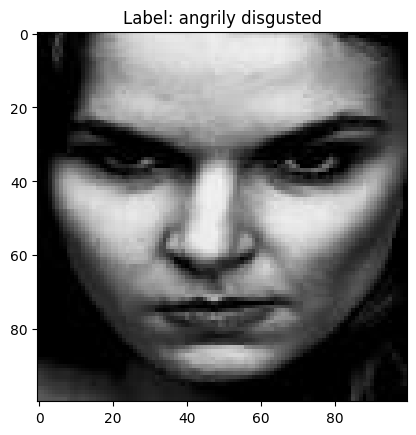

In [18]:
# Test de diagnostic immédiat
sample = test_dataset[0]
print(f"Path: {sample['image_path']}")
print(f"Exists: {Path(sample['image_path']).exists()}")
print(f"Image shape: {sample['image'].size if hasattr(sample['image'], 'size') else 'NO IMAGE'}")

# Afficher l'image
if sample['image'] is not None:
    plt.imshow(sample['image'])
    plt.title(f"Label: {sample['label_text']}")
    plt.show()

In [19]:
# Résumé
print(f"\n{'='*60}")
print("📊 RÉSUMÉ DU TEST")
print(f"{'='*60}")
correct_count = sum(r['correct'] for r in results)
accuracy = correct_count / len(results)
avg_time = np.mean([r['time'] for r in results])

print(f"Accuracy: {correct_count}/{len(results)} = {accuracy:.2%}")
print(f"Temps moyen: {avg_time:.3f}s par image")
print(f"Débit: {1/avg_time:.2f} images/seconde")



📊 RÉSUMÉ DU TEST
Accuracy: 0/5 = 0.00%
Temps moyen: 1.412s par image
Débit: 0.71 images/seconde


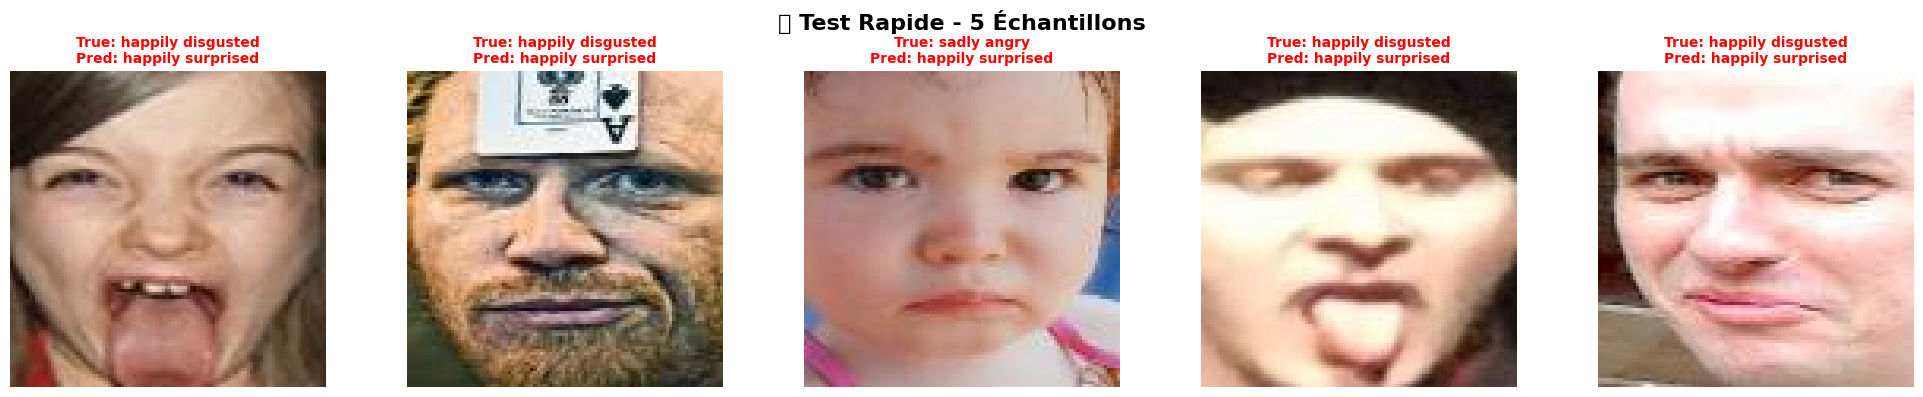

In [20]:
# Visualisation
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, (ax, test_idx) in enumerate(zip(axes, test_indices)):
    sample = test_dataset[test_idx]
    image = sample['image']
    true_label = sample['label_text']
    pred_label = results[idx]['predicted_label'] if results[idx]['predicted_label'] else 'Unknown'
    is_correct = results[idx]['correct']

    ax.imshow(image)
    ax.axis('off')

    color = 'green' if is_correct else 'red'
    ax.set_title(f"True: {true_label}\nPred: {pred_label}",
                 color=color, fontsize=10, fontweight='bold')

plt.suptitle('🧪 Test Rapide - 5 Échantillons', fontsize=16, fontweight='bold')
plt.tight_layout()


In [21]:
# Sauvegarder
save_path = Config.RESULTS_DIR / 'quick_test_samples.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f"\n💾 Visualisation sauvegardée: {save_path}")

plt.show()

print("\n" + "="*80)
print("✅ TEST RAPIDE TERMINÉ!")
print("="*80)
print("\nProchaines étapes:")
print("  1. Si le test fonctionne bien, passez à l'évaluation complète")
print("  2. Ensuite, lancez le fine-tuning LoRA")
print("  3. Comparez avec les baselines")



💾 Visualisation sauvegardée: /content/drive/Shareddrives/Vision-LLM-Project-Team/results/quick_test_samples.png


<Figure size 640x480 with 0 Axes>


✅ TEST RAPIDE TERMINÉ!

Prochaines étapes:
  1. Si le test fonctionne bien, passez à l'évaluation complète
  2. Ensuite, lancez le fine-tuning LoRA
  3. Comparez avec les baselines


In [22]:
# Évaluation sur tout le test set
print("🔍 Évaluation complète du test set...")

all_predictions = []
all_ground_truth = []
all_times = []

for i in tqdm(range(len(test_dataset))):
    sample = test_dataset[i]
    result = predict_emotion(sample['image'], model, processor)

    all_predictions.append(result['predicted_emotion'])
    all_ground_truth.append(sample['label'])
    all_times.append(result['inference_time'])

# Calculer les métriques
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Filtrer les prédictions valides
valid_mask = [p is not None for p in all_predictions]
valid_preds = [p for p, v in zip(all_predictions, valid_mask) if v]
valid_gt = [g for g, v in zip(all_ground_truth, valid_mask) if v]

accuracy = np.mean([p == g for p, g in zip(valid_preds, valid_gt)])
f1_macro = f1_score(valid_gt, valid_preds, average='macro')

print(f"\\nRésultats Zero-Shot BLIP-2:")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1 Score: {f1_macro:.4f}")
print(f"  Temps moyen: {np.mean(all_times):.3f}s")

🔍 Évaluation complète du test set...


100%|██████████| 909/909 [11:04<00:00,  1.37it/s]

\nRésultats Zero-Shot BLIP-2:
  Accuracy: 0.1386
  F1 Score: 0.0174
  Temps moyen: 0.723s


In [23]:
# Recharger avec LoRA
processor, model_lora = load_blip2_model(use_4bit=True, use_lora=True)

# Créer le train dataset
train_dataset = RAFCEVisionLLMDataset(
    Config.DATA_DIR,
    Config.LABEL_FILE,
    Config.PARTITION_FILE,
    processor,
    split='train'
)


🔄 Chargement de Salesforce/blip2-opt-2.7b...
  - Quantization 4-bit: ✓
  - LoRA: ✓
  🔧 Configuration 4-bit créée
  📥 Chargement du processor...
  📥 Chargement du modèle (cela peut prendre 1-2 minutes)...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  ✅ Modèle chargé sur cuda:0

  🔧 Application de LoRA...
trainable params: 3,932,160 || all params: 3,748,694,016 || trainable%: 0.1049

  📊 Statistiques du modèle:
    Total params: 1997.4M
    Trainable params: 3.9M (0.20%)
  Chargement des labels depuis /content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/RAFCE_emolabel.txt...
  ✓ TRAIN set: 2709 images
  Distribution des classes:
     0. happily surprised         : 394 images
     1. happily disgusted         : 171 images
     2. sadly fearful             : 109 images
     3. sadly angry               : 136 images
     4. sadly surprised           :  71 images
     5. sadly disgusted           : 495 images
     6. fearfully angry           : 120 images
     7. fearfully surprised       : 352 images
     8. fearfully disgusted       :  24 images
     9. angrily surprised         : 124 images
    10. angrily disgusted         : 582 images
    11. disgustedly surprised     : 108 images
    12. happily fearful           :   


🎓 PHASE 9: FINE-TUNING BLIP-2 AVEC LoRA

📦 Création du DataLoader...
  ✅ 1355 batches de 2 images
  📊 Total images: 2709

⚙️ Configuration de l'optimiseur...
  ✅ AdamW avec LR=0.0001
  ✅ Cosine Annealing Scheduler

🚀 DÉBUT DE L'ENTRAÎNEMENT

📍 EPOCH 1/3


Epoch 1: 100%|██████████| 1355/1355 [19:39<00:00,  1.15it/s, loss=0.0144, lr=9.83e-05]



📊 Résultats Epoch 1:
  Loss moyenne: 0.3341
  Learning rate: 9.83e-05
  Temps: 1179.5s (19.7 min)
  Batches traités: 1355/1355

💾 Sauvegarde du checkpoint...
  ✅ Checkpoint sauvegardé: /content/drive/Shareddrives/Vision-LLM-Project-Team/models/checkpoints/blip2_lora_epoch1
  🏆 Nouveau meilleur modèle sauvegardé! (loss: 0.3341)

📍 EPOCH 2/3


Epoch 2: 100%|██████████| 1355/1355 [19:35<00:00,  1.15it/s, loss=0.0058, lr=9.34e-05]



📊 Résultats Epoch 2:
  Loss moyenne: 0.0125
  Learning rate: 9.34e-05
  Temps: 1175.7s (19.6 min)
  Batches traités: 1355/1355

💾 Sauvegarde du checkpoint...
  ✅ Checkpoint sauvegardé: /content/drive/Shareddrives/Vision-LLM-Project-Team/models/checkpoints/blip2_lora_epoch2
  🏆 Nouveau meilleur modèle sauvegardé! (loss: 0.0125)

📍 EPOCH 3/3


Epoch 3: 100%|██████████| 1355/1355 [19:33<00:00,  1.15it/s, loss=0.0059, lr=8.56e-05]



📊 Résultats Epoch 3:
  Loss moyenne: 0.0095
  Learning rate: 8.56e-05
  Temps: 1173.2s (19.6 min)
  Batches traités: 1355/1355

💾 Sauvegarde du checkpoint...
  ✅ Checkpoint sauvegardé: /content/drive/Shareddrives/Vision-LLM-Project-Team/models/checkpoints/blip2_lora_epoch3
  🏆 Nouveau meilleur modèle sauvegardé! (loss: 0.0095)

✅ ENTRAÎNEMENT TERMINÉ!

📈 Génération des graphiques...
  ✅ Graphiques sauvegardés: /content/drive/Shareddrives/Vision-LLM-Project-Team/results/training_curves.png


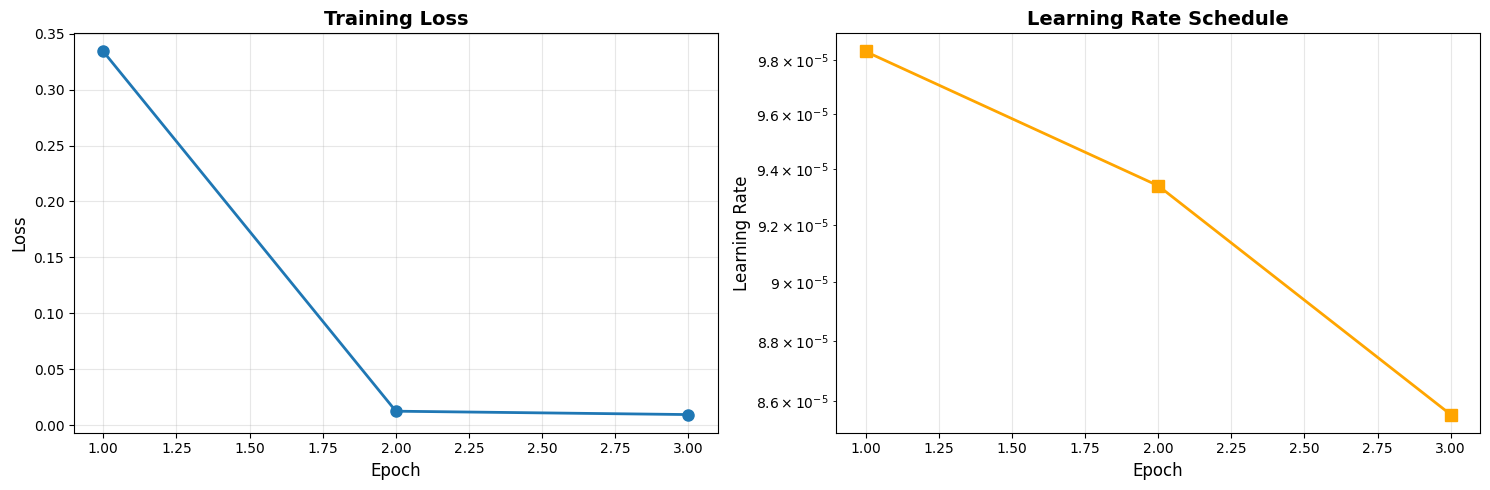


📋 RÉSUMÉ DE L'ENTRAÎNEMENT:
  Epochs complétés: 3
  Loss finale: 0.0095
  Meilleure loss: 0.0095
  Temps total: 3528.4s (58.8 min)
  Modèles sauvegardés dans: /content/drive/Shareddrives/Vision-LLM-Project-Team/models
  Résultats sauvegardés dans: /content/drive/Shareddrives/Vision-LLM-Project-Team/results

🎯 Prochaine étape: Évaluation sur le test set!


In [24]:
# %% TRAINING LOOP COMPLET - BLIP-2 + LoRA
print("\n" + "="*80)
print("🎓 PHASE 9: FINE-TUNING BLIP-2 AVEC LoRA")
print("="*80)

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# ✅ CORRECTION: Utiliser torch.optim au lieu de transformers
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

# Préparer le DataLoader
print("\n📦 Création du DataLoader...")
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"  ✅ {len(train_loader)} batches de {Config.BATCH_SIZE} images")
print(f"  📊 Total images: {len(train_dataset)}")

# Configurer l'optimiseur
print("\n⚙️ Configuration de l'optimiseur...")
optimizer = AdamW(
    model_lora.parameters(),
    lr=Config.LEARNING_RATE,
    weight_decay=0.01
)

# Scheduler optionnel
scheduler = CosineAnnealingLR(
    optimizer,
    T_max=Config.NUM_EPOCHS * len(train_loader),
    eta_min=1e-6
)

print(f"  ✅ AdamW avec LR={Config.LEARNING_RATE}")
print(f"  ✅ Cosine Annealing Scheduler")

# Fonction de collate personnalisée
def collate_fn(batch):
    """Prépare un batch pour BLIP-2"""
    images = [item['image'] for item in batch]
    prompts = [item['prompt'] for item in batch]
    targets = [item['target'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch])

    return {
        'images': images,
        'prompts': prompts,
        'targets': targets,
        'labels': labels
    }

# Recréer le DataLoader avec collate_fn
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

# Boucle d'entraînement
print("\n" + "="*80)
print("🚀 DÉBUT DE L'ENTRAÎNEMENT")
print("="*80)

training_history = {
    'epoch': [],
    'train_loss': [],
    'learning_rate': [],
    'time_per_epoch': []
}

best_loss = float('inf')

for epoch in range(Config.NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"📍 EPOCH {epoch + 1}/{Config.NUM_EPOCHS}")
    print(f"{'='*60}")

    model_lora.train()
    total_loss = 0
    num_batches = 0
    epoch_start = time.time()

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch_idx, batch in enumerate(progress_bar):
        try:
            # Préparer les inputs pour BLIP-2
            # Format: "Question: {prompt} Answer: {target}"
            formatted_texts = [
                f"Question: {prompt} Answer: {target}"
                for prompt, target in zip(batch['prompts'], batch['targets'])
            ]

            # Traiter avec le processor
            inputs = processor(
                images=batch['images'],
                text=formatted_texts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            )

            # Déplacer sur GPU
            inputs = {k: v.to(model_lora.device) for k, v in inputs.items()}

            # Forward pass
            outputs = model_lora(**inputs, labels=inputs['input_ids'])
            loss = outputs.loss

            # Backward pass avec gradient accumulation
            loss = loss / Config.GRADIENT_ACCUMULATION_STEPS
            loss.backward()

            # Mise à jour des poids
            if (batch_idx + 1) % Config.GRADIENT_ACCUMULATION_STEPS == 0:
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model_lora.parameters(), max_norm=1.0)

                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            # Accumuler la loss
            total_loss += loss.item() * Config.GRADIENT_ACCUMULATION_STEPS
            num_batches += 1

            # Mettre à jour la progress bar
            current_lr = optimizer.param_groups[0]['lr']
            progress_bar.set_postfix({
                'loss': f"{loss.item() * Config.GRADIENT_ACCUMULATION_STEPS:.4f}",
                'lr': f"{current_lr:.2e}"
            })

            # Libérer la mémoire
            del inputs, outputs, loss
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"\n⚠️ Erreur batch {batch_idx}: {e}")
            continue

    # Calculer les métriques de l'epoch
    epoch_time = time.time() - epoch_start
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    current_lr = optimizer.param_groups[0]['lr']

    print(f"\n📊 Résultats Epoch {epoch + 1}:")
    print(f"  Loss moyenne: {avg_loss:.4f}")
    print(f"  Learning rate: {current_lr:.2e}")
    print(f"  Temps: {epoch_time:.1f}s ({epoch_time/60:.1f} min)")
    print(f"  Batches traités: {num_batches}/{len(train_loader)}")

    # Sauvegarder l'historique
    training_history['epoch'].append(epoch + 1)
    training_history['train_loss'].append(avg_loss)
    training_history['learning_rate'].append(current_lr)
    training_history['time_per_epoch'].append(epoch_time)

    # Sauvegarder le checkpoint
    checkpoint_dir = Config.CHECKPOINTS_DIR / f"blip2_lora_epoch{epoch+1}"
    checkpoint_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n💾 Sauvegarde du checkpoint...")
    model_lora.save_pretrained(checkpoint_dir)
    processor.save_pretrained(checkpoint_dir)

    # Sauvegarder aussi l'historique
    import json
    history_path = Config.RESULTS_DIR / 'training_history.json'
    with open(history_path, 'w') as f:
        json.dump(training_history, f, indent=2)

    print(f"  ✅ Checkpoint sauvegardé: {checkpoint_dir}")

    # Sauvegarder le meilleur modèle
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_dir = Config.MODELS_DIR / "blip2_lora_best"
        best_model_dir.mkdir(parents=True, exist_ok=True)
        model_lora.save_pretrained(best_model_dir)
        processor.save_pretrained(best_model_dir)
        print(f"  🏆 Nouveau meilleur modèle sauvegardé! (loss: {best_loss:.4f})")

print("\n" + "="*80)
print("✅ ENTRAÎNEMENT TERMINÉ!")
print("="*80)

# Visualiser l'historique d'entraînement
print("\n📈 Génération des graphiques...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curve
axes[0].plot(training_history['epoch'], training_history['train_loss'],
             marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Learning rate curve
axes[1].plot(training_history['epoch'], training_history['learning_rate'],
             marker='s', linewidth=2, markersize=8, color='orange')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = Config.RESULTS_DIR / 'training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"  ✅ Graphiques sauvegardés: {plot_path}")
plt.show()

# Résumé final
print("\n📋 RÉSUMÉ DE L'ENTRAÎNEMENT:")
print(f"  Epochs complétés: {Config.NUM_EPOCHS}")
print(f"  Loss finale: {training_history['train_loss'][-1]:.4f}")
print(f"  Meilleure loss: {best_loss:.4f}")
print(f"  Temps total: {sum(training_history['time_per_epoch']):.1f}s ({sum(training_history['time_per_epoch'])/60:.1f} min)")
print(f"  Modèles sauvegardés dans: {Config.MODELS_DIR}")
print(f"  Résultats sauvegardés dans: {Config.RESULTS_DIR}")

print("\n🎯 Prochaine étape: Évaluation sur le test set!")


📊 PHASE 10: ÉVALUATION COMPLÈTE SUR TEST SET

📥 Chargement du meilleur modèle fine-tuné...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  ✅ Modèle chargé depuis /content/drive/Shareddrives/Vision-LLM-Project-Team/models/blip2_lora_best

📦 Préparation du test dataset...
  Chargement des labels depuis /content/drive/Shareddrives/Vision-LLM-Project-Team/dataset/raw/RAFCE_emolabel.txt...
  ✓ TEST set: 909 images
  Distribution des classes:
     0. happily surprised         : 126 images
     1. happily disgusted         :  54 images
     2. sadly fearful             :  36 images
     3. sadly angry               :  44 images
     4. sadly surprised           :  25 images
     5. sadly disgusted           : 178 images
     6. fearfully angry           :  43 images
     7. fearfully surprised       : 113 images
     8. fearfully disgusted       :   6 images
     9. angrily surprised         :  44 images
    10. angrily disgusted         : 194 images
    11. disgustedly surprised     :  37 images
    12. happily fearful           :   1 images
    13. happily sad               :   8 images
  ✅ 909 images de test

🚀 DÉBUT DE L'É

Test set: 100%|██████████| 909/909 [10:00<00:00,  1.51it/s]



✅ Évaluation terminée:
  Prédictions réussies: 909/909
  Prédictions échouées: 0

📈 Calcul des métriques...
  💾 Prédictions détaillées sauvegardées: /content/drive/Shareddrives/Vision-LLM-Project-Team/results/detailed_predictions.json

📊 RÉSULTATS DE L'ÉVALUATION

🎯 Métriques Globales:
  Accuracy:           0.1386 (13.86%)
  F1-Score (Macro):   0.0174
  F1-Score (Weighted):0.0337
  Precision (Macro):  0.0099
  Recall (Macro):     0.0714

⏱️ Performance:
  Temps moyen/image:  0.650s
  Débit:              1.54 images/sec

📈 Statistiques:
  Total échantillons: 909
  Prédictions OK:     909
  Échecs:             0

🏆 Top 5 Classes (F1-Score):
  1. happily surprised         - F1: 0.2435 (support: 126)
  2. happily disgusted         - F1: 0.0000 (support: 54)
  3. sadly fearful             - F1: 0.0000 (support: 36)
  4. sadly angry               - F1: 0.0000 (support: 44)
  5. sadly surprised           - F1: 0.0000 (support: 25)

📉 Bottom 5 Classes (F1-Score):
  1. angrily surprised       

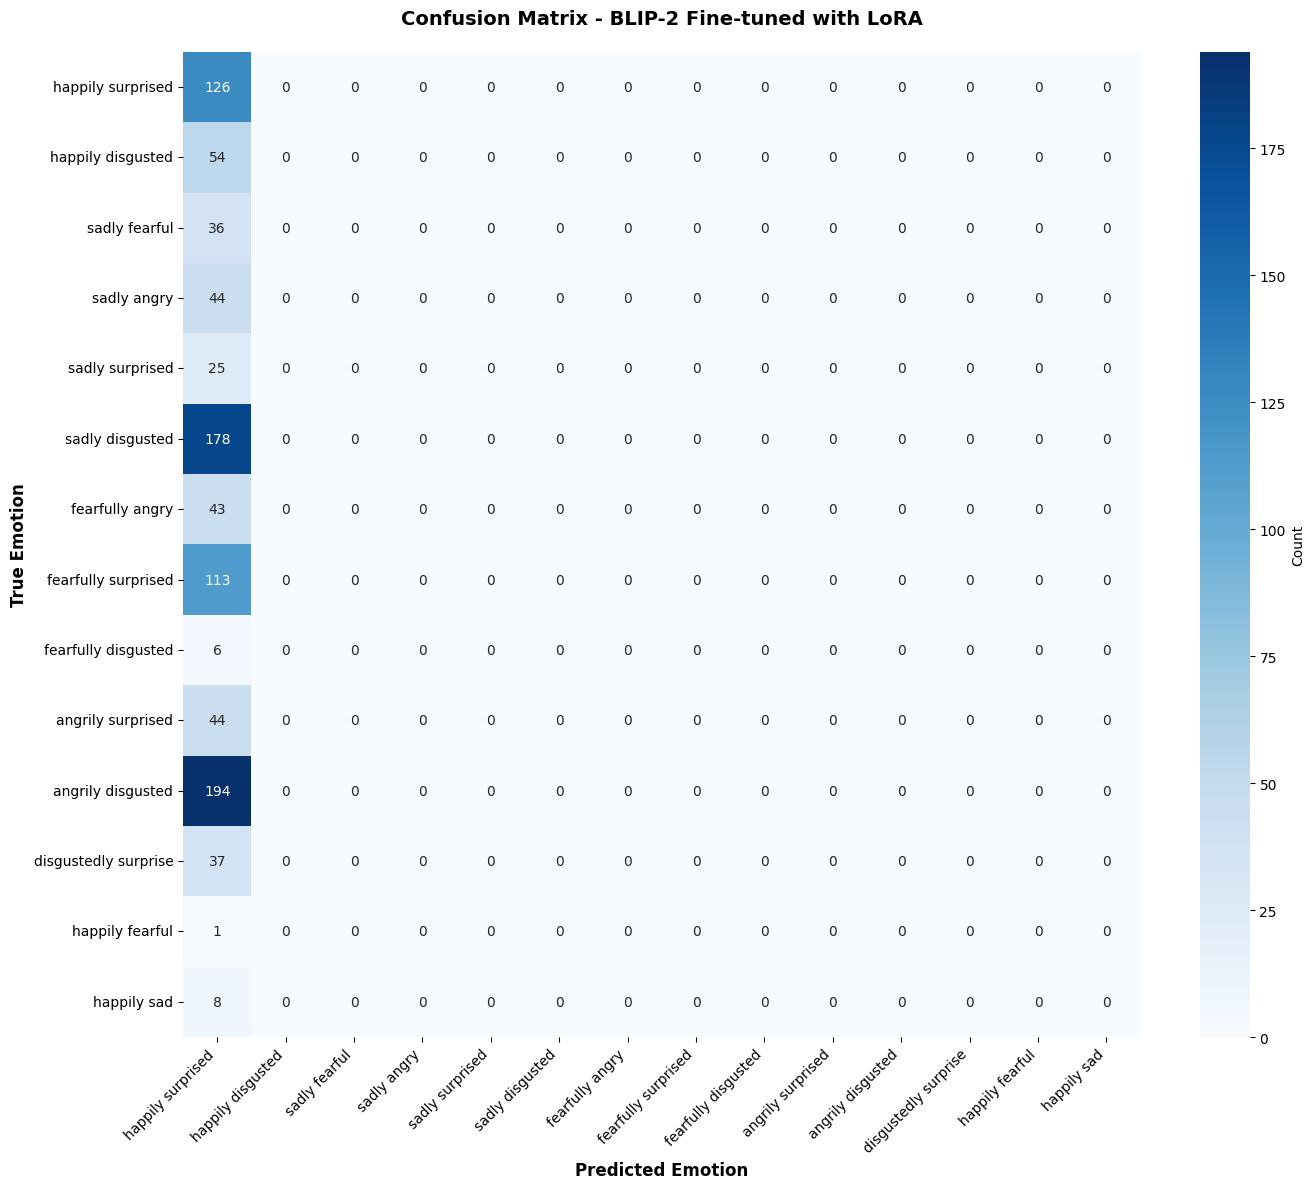

  ✅ Performance par classe: /content/drive/Shareddrives/Vision-LLM-Project-Team/results/per_class_performance.png


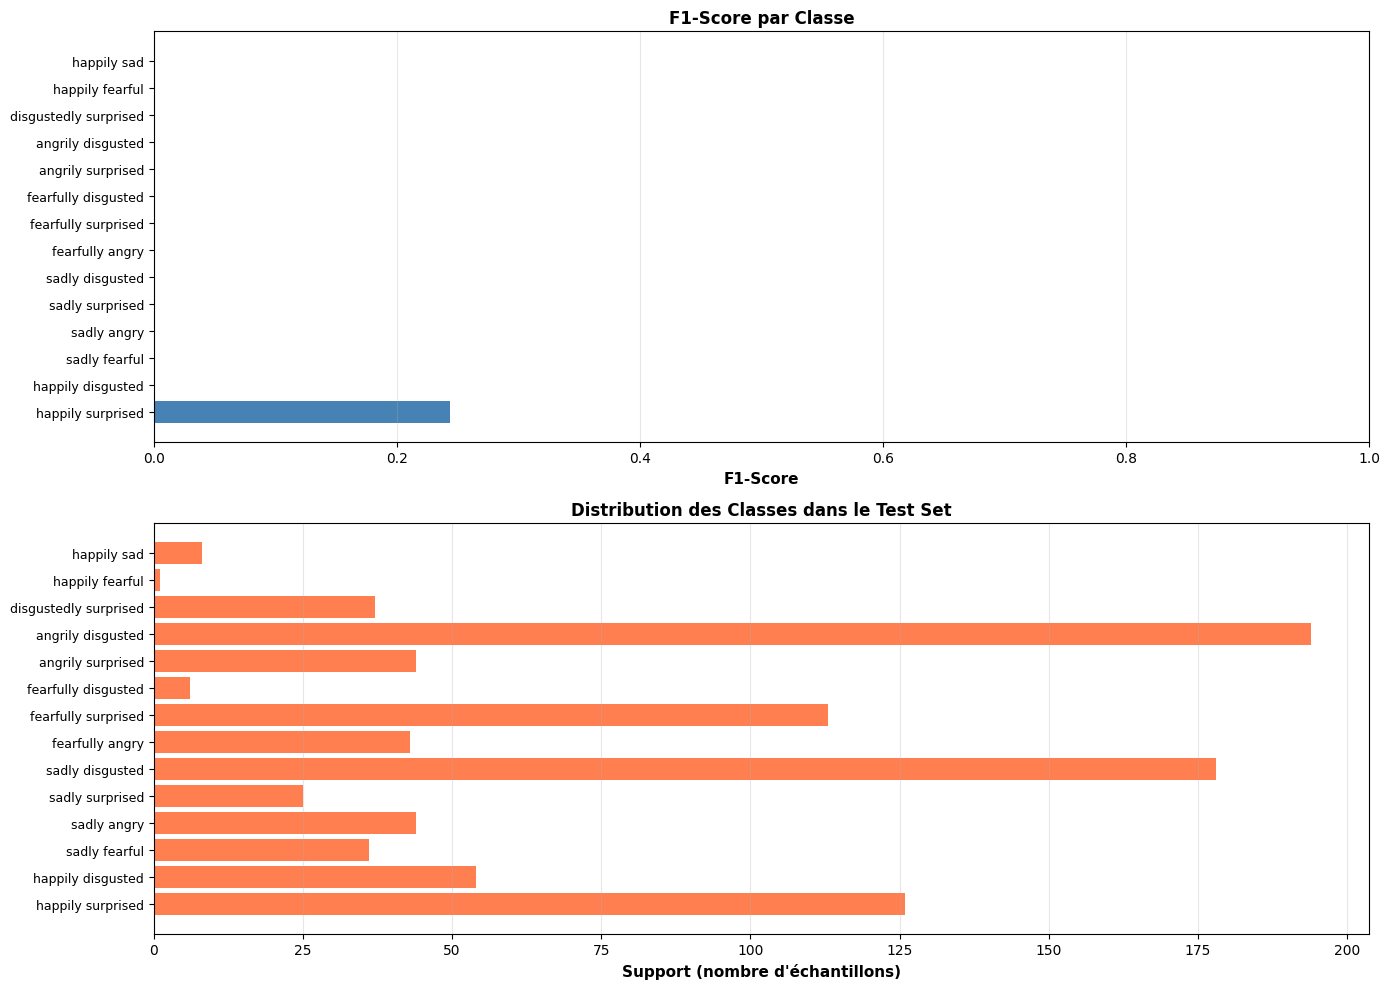


💾 Résultats sauvegardés: /content/drive/Shareddrives/Vision-LLM-Project-Team/results/evaluation_results_finetuned.json

✅ ÉVALUATION COMPLÈTE TERMINÉE!


In [25]:
# %% PHASE 10: ÉVALUATION COMPLÈTE DU MODÈLE FINE-TUNÉ
print("\n" + "="*80)
print("📊 PHASE 10: ÉVALUATION COMPLÈTE SUR TEST SET")
print("="*80)

import torch
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import json

# Charger le meilleur modèle
print("\n📥 Chargement du meilleur modèle fine-tuné...")
best_model_path = Config.MODELS_DIR / "blip2_lora_best"

if best_model_path.exists():
    from peft import PeftModel

    # Recharger le modèle de base
    base_model = Blip2ForConditionalGeneration.from_pretrained(
        Config.MODEL_NAME,
        quantization_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4"
        ),
        device_map="auto",
        torch_dtype=torch.float16
    )

    # Charger les poids LoRA
    model_finetuned = PeftModel.from_pretrained(base_model, best_model_path)
    model_finetuned.eval()

    print(f"  ✅ Modèle chargé depuis {best_model_path}")
else:
    print("  ⚠️ Pas de modèle fine-tuné trouvé, utilisation du modèle actuel")
    model_finetuned = model_lora
    model_finetuned.eval()

# Créer le test dataset si pas déjà fait
print("\n📦 Préparation du test dataset...")
test_dataset = RAFCEVisionLLMDataset(
    Config.DATA_DIR,
    Config.LABEL_FILE,
    Config.PARTITION_FILE,
    processor,
    split='test'
)
print(f"  ✅ {len(test_dataset)} images de test")

# Fonction d'évaluation complète
@torch.no_grad()
def evaluate_full(model, processor, dataset, save_predictions=True):
    """
    Évaluation complète avec toutes les métriques

    Returns:
        dict: Dictionnaire contenant toutes les métriques
    """
    model.eval()

    all_predictions = []
    all_ground_truth = []
    all_generated_texts = []
    all_inference_times = []
    failed_predictions = 0

    print("\n🔍 Évaluation en cours...")

    for idx in tqdm(range(len(dataset)), desc="Test set"):
        sample = dataset[idx]

        try:
            # Prédiction
            result = predict_emotion(sample['image'], model, processor)

            pred_label = result['predicted_emotion']
            true_label = sample['label']

            # Si la prédiction a échoué (None), utiliser une prédiction aléatoire
            if pred_label is None:
                pred_label = -1  # Marqueur d'échec
                failed_predictions += 1

            all_predictions.append(pred_label)
            all_ground_truth.append(true_label)
            all_generated_texts.append(result['generated_text'])
            all_inference_times.append(result['inference_time'])

        except Exception as e:
            print(f"\n⚠️ Erreur sur l'image {idx}: {e}")
            all_predictions.append(-1)
            all_ground_truth.append(sample['label'])
            all_generated_texts.append("")
            all_inference_times.append(0)
            failed_predictions += 1

    # Filtrer les prédictions échouées pour les métriques
    valid_indices = [i for i, p in enumerate(all_predictions) if p != -1]
    valid_predictions = [all_predictions[i] for i in valid_indices]
    valid_ground_truth = [all_ground_truth[i] for i in valid_indices]

    print(f"\n✅ Évaluation terminée:")
    print(f"  Prédictions réussies: {len(valid_predictions)}/{len(dataset)}")
    print(f"  Prédictions échouées: {failed_predictions}")

    # Calculer les métriques
    print("\n📈 Calcul des métriques...")

    accuracy = accuracy_score(valid_ground_truth, valid_predictions)
    f1_macro = f1_score(valid_ground_truth, valid_predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(valid_ground_truth, valid_predictions, average='weighted', zero_division=0)
    precision = precision_score(valid_ground_truth, valid_predictions, average='macro', zero_division=0)
    recall = recall_score(valid_ground_truth, valid_predictions, average='macro', zero_division=0)

    # Matrice de confusion
    cm = confusion_matrix(valid_ground_truth, valid_predictions)

    # Rapport détaillé
    class_names = [Config.CLASSES[i] for i in range(Config.NUM_CLASSES)]
    report = classification_report(
        valid_ground_truth,
        valid_predictions,
        target_names=class_names,
        zero_division=0,
        output_dict=True
    )

    # Métriques par classe
    per_class_metrics = {}
    for i, class_name in enumerate(class_names):
        if class_name in report:
            per_class_metrics[class_name] = {
                'precision': report[class_name]['precision'],
                'recall': report[class_name]['recall'],
                'f1-score': report[class_name]['f1-score'],
                'support': report[class_name]['support']
            }

    # Temps d'inférence
    avg_inference_time = np.mean([t for t in all_inference_times if t > 0])

    results = {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision,
        'recall_macro': recall,
        'confusion_matrix': cm.tolist(),
        'per_class_metrics': per_class_metrics,
        'avg_inference_time': avg_inference_time,
        'total_samples': len(dataset),
        'successful_predictions': len(valid_predictions),
        'failed_predictions': failed_predictions,
        'all_predictions': all_predictions,
        'all_ground_truth': all_ground_truth,
        'all_generated_texts': all_generated_texts
    }

    # Sauvegarder les prédictions détaillées
    if save_predictions:
        predictions_path = Config.RESULTS_DIR / 'detailed_predictions.json'
        detailed_preds = {
            'predictions': [
                {
                    'index': i,
                    'true_label': int(gt),
                    'true_emotion': Config.CLASSES.get(gt, 'unknown'),
                    'predicted_label': int(pred) if pred != -1 else None,
                    'predicted_emotion': Config.CLASSES.get(pred, 'unknown') if pred != -1 else None,
                    'generated_text': text,
                    'correct': pred == gt
                }
                for i, (gt, pred, text) in enumerate(zip(all_ground_truth, all_predictions, all_generated_texts))
            ]
        }

        with open(predictions_path, 'w') as f:
            json.dump(detailed_preds, f, indent=2)

        print(f"  💾 Prédictions détaillées sauvegardées: {predictions_path}")

    return results

# Lancer l'évaluation
print("\n" + "="*80)
print("🚀 DÉBUT DE L'ÉVALUATION")
print("="*80)

results = evaluate_full(model_finetuned, processor, test_dataset)

# Afficher les résultats
print("\n" + "="*80)
print("📊 RÉSULTATS DE L'ÉVALUATION")
print("="*80)

print(f"\n🎯 Métriques Globales:")
print(f"  Accuracy:           {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)")
print(f"  F1-Score (Macro):   {results['f1_macro']:.4f}")
print(f"  F1-Score (Weighted):{results['f1_weighted']:.4f}")
print(f"  Precision (Macro):  {results['precision_macro']:.4f}")
print(f"  Recall (Macro):     {results['recall_macro']:.4f}")

print(f"\n⏱️ Performance:")
print(f"  Temps moyen/image:  {results['avg_inference_time']:.3f}s")
print(f"  Débit:              {1/results['avg_inference_time']:.2f} images/sec")

print(f"\n📈 Statistiques:")
print(f"  Total échantillons: {results['total_samples']}")
print(f"  Prédictions OK:     {results['successful_predictions']}")
print(f"  Échecs:             {results['failed_predictions']}")

# Top 5 et Bottom 5 classes
print(f"\n🏆 Top 5 Classes (F1-Score):")
sorted_classes = sorted(
    results['per_class_metrics'].items(),
    key=lambda x: x[1]['f1-score'],
    reverse=True
)
for i, (class_name, metrics) in enumerate(sorted_classes[:5], 1):
    print(f"  {i}. {class_name:25s} - F1: {metrics['f1-score']:.4f} (support: {int(metrics['support'])})")

print(f"\n📉 Bottom 5 Classes (F1-Score):")
for i, (class_name, metrics) in enumerate(sorted_classes[-5:], 1):
    print(f"  {i}. {class_name:25s} - F1: {metrics['f1-score']:.4f} (support: {int(metrics['support'])})")

# Visualisations
print("\n📊 Génération des visualisations...")

# 1. Matrice de confusion
fig, ax = plt.subplots(figsize=(14, 12))
cm = np.array(results['confusion_matrix'])
class_names_short = [name[:20] for name in Config.CLASSES.values()]

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names_short,
    yticklabels=class_names_short,
    ax=ax,
    cbar_kws={'label': 'Count'}
)

ax.set_xlabel('Predicted Emotion', fontsize=12, fontweight='bold')
ax.set_ylabel('True Emotion', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - BLIP-2 Fine-tuned with LoRA',
             fontsize=14, fontweight='bold', pad=20)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

cm_path = Config.RESULTS_DIR / 'confusion_matrix_finetuned.png'
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"  ✅ Matrice de confusion: {cm_path}")
plt.show()

# 2. Performance par classe
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

class_names = list(results['per_class_metrics'].keys())
f1_scores = [results['per_class_metrics'][c]['f1-score'] for c in class_names]
supports = [results['per_class_metrics'][c]['support'] for c in class_names]

# F1-Scores
axes[0].barh(range(len(class_names)), f1_scores, color='steelblue')
axes[0].set_yticks(range(len(class_names)))
axes[0].set_yticklabels(class_names, fontsize=9)
axes[0].set_xlabel('F1-Score', fontsize=11, fontweight='bold')
axes[0].set_title('F1-Score par Classe', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim([0, 1])

# Support
axes[1].barh(range(len(class_names)), supports, color='coral')
axes[1].set_yticks(range(len(class_names)))
axes[1].set_yticklabels(class_names, fontsize=9)
axes[1].set_xlabel('Support (nombre d\'échantillons)', fontsize=11, fontweight='bold')
axes[1].set_title('Distribution des Classes dans le Test Set', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
perf_path = Config.RESULTS_DIR / 'per_class_performance.png'
plt.savefig(perf_path, dpi=300, bbox_inches='tight')
print(f"  ✅ Performance par classe: {perf_path}")
plt.show()

# Sauvegarder les résultats en JSON
results_json = {
    'model': 'BLIP-2 + LoRA Fine-tuned',
    'dataset': 'RAF-CE',
    'metrics': {
        'accuracy': float(results['accuracy']),
        'f1_macro': float(results['f1_macro']),
        'f1_weighted': float(results['f1_weighted']),
        'precision_macro': float(results['precision_macro']),
        'recall_macro': float(results['recall_macro'])
    },
    'performance': {
        'avg_inference_time': float(results['avg_inference_time']),
        'throughput': float(1/results['avg_inference_time'])
    },
    'statistics': {
        'total_samples': results['total_samples'],
        'successful_predictions': results['successful_predictions'],
        'failed_predictions': results['failed_predictions']
    },
    'per_class_metrics': results['per_class_metrics'],
    'confusion_matrix': results['confusion_matrix']
}

results_json_path = Config.RESULTS_DIR / 'evaluation_results_finetuned.json'
with open(results_json_path, 'w') as f:
    json.dump(results_json, f, indent=2)

print(f"\n💾 Résultats sauvegardés: {results_json_path}")

print("\n" + "="*80)
print("✅ ÉVALUATION COMPLÈTE TERMINÉE!")
print("="*80)

In [ ]:
# %% PHASE 11: COMPARAISON ZERO-SHOT VS FINE-TUNÉ
print("\n" + "="*80)
print("📊 PHASE 11: COMPARAISON ZERO-SHOT VS FINE-TUNÉ")
print("="*80)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Évaluer le modèle zero-shot (original)
print("\n🔍 Évaluation du modèle Zero-Shot...")
print("  (Cela peut prendre 5-10 minutes)")

results_zeroshot = evaluate_full(model, processor, test_dataset, save_predictions=False)

print(f"\n✅ Zero-Shot évalué:")
print(f"  Accuracy: {results_zeroshot['accuracy']:.4f}")
print(f"  F1-Macro: {results_zeroshot['f1_macro']:.4f}")

# Les résultats fine-tuned sont déjà dans 'results'
results_finetuned = results

# Créer un tableau comparatif
comparison_data = {
    'Model': ['BLIP-2 Zero-Shot', 'BLIP-2 Fine-tuned (LoRA)'],
    'Accuracy': [
        results_zeroshot['accuracy'],
        results_finetuned['accuracy']
    ],
    'F1-Score (Macro)': [
        results_zeroshot['f1_macro'],
        results_finetuned['f1_macro']
    ],
    'F1-Score (Weighted)': [
        results_zeroshot['f1_weighted'],
        results_finetuned['f1_weighted']
    ],
    'Precision': [
        results_zeroshot['precision_macro'],
        results_finetuned['precision_macro']
    ],
    'Recall': [
        results_zeroshot['recall_macro'],
        results_finetuned['recall_macro']
    ],
    'Inference Time (s)': [
        results_zeroshot['avg_inference_time'],
        results_finetuned['avg_inference_time']
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("📊 TABLEAU COMPARATIF")
print("="*80)
print(df_comparison.to_string(index=False))

# Calculer l'amélioration
improvement = {
    'Accuracy': (results_finetuned['accuracy'] - results_zeroshot['accuracy']) / results_zeroshot['accuracy'] * 100,
    'F1-Macro': (results_finetuned['f1_macro'] - results_zeroshot['f1_macro']) / results_zeroshot['f1_macro'] * 100,
}

print(f"\n📈 AMÉLIORATION APRÈS FINE-TUNING:")
print(f"  Accuracy:  {improvement['Accuracy']:+.2f}%")
print(f"  F1-Macro:  {improvement['F1-Macro']:+.2f}%")

# Visualisation comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Barplot des métriques principales
metrics = ['Accuracy', 'F1-Score (Macro)', 'Precision', 'Recall']
x = np.arange(len(metrics))
width = 0.35

zeroshot_values = [
    results_zeroshot['accuracy'],
    results_zeroshot['f1_macro'],
    results_zeroshot['precision_macro'],
    results_zeroshot['recall_macro']
]

finetuned_values = [
    results_finetuned['accuracy'],
    results_finetuned['f1_macro'],
    results_finetuned['precision_macro'],
    results_finetuned['recall_macro']
]

axes[0].bar(x - width/2, zeroshot_values, width, label='Zero-Shot', color='steelblue', alpha=0.8)
axes[0].bar(x + width/2, finetuned_values, width, label='Fine-tuned', color='coral', alpha=0.8)
axes[0].set_xlabel('Métriques', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=11, fontweight='bold')
axes[0].set_title('Comparaison des Métriques', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# 2. Heatmap de comparaison par classe (F1-Score)
class_names = list(results_zeroshot['per_class_metrics'].keys())
f1_comparison = []

for class_name in class_names:
    f1_zero = results_zeroshot['per_class_metrics'][class_name]['f1-score']
    f1_fine = results_finetuned['per_class_metrics'][class_name]['f1-score']
    f1_comparison.append([f1_zero, f1_fine])

f1_comparison = np.array(f1_comparison)

im = axes[1].imshow(f1_comparison.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
axes[1].set_xticks(range(len(class_names)))
axes[1].set_xticklabels([c[:15] for c in class_names], rotation=90, fontsize=8)
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Zero-Shot', 'Fine-tuned'])
axes[1].set_title('F1-Score par Classe', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1], label='F1-Score')

# 3. Différence de performance
f1_diff = f1_comparison[:, 1] - f1_comparison[:, 0]
colors = ['green' if d > 0 else 'red' for d in f1_diff]

axes[2].barh(range(len(class_names)), f1_diff, color=colors, alpha=0.7)
axes[2].set_yticks(range(len(class_names)))
axes[2].set_yticklabels([c[:20] for c in class_names], fontsize=9)
axes[2].set_xlabel('Δ F1-Score (Fine-tuned - Zero-Shot)', fontsize=10, fontweight='bold')
axes[2].set_title('Amélioration par Classe', fontsize=12, fontweight='bold')
axes[2].axvline(0, color='black', linewidth=0.8, linestyle='--')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
comparison_path = Config.RESULTS_DIR / 'comparison_zeroshot_vs_finetuned.png'
plt.savefig(comparison_path, dpi=300, bbox_inches='tight')
print(f"\n💾 Visualisation sauvegardée: {comparison_path}")
plt.show()

# Sauvegarder le tableau comparatif
comparison_path_csv = Config.RESULTS_DIR / 'model_comparison.csv'
df_comparison.to_csv(comparison_path_csv, index=False)
print(f"💾 Tableau CSV sauvegardé: {comparison_path_csv}")

# Sauvegarder la comparaison détaillée en JSON
comparison_json = {
    'zero_shot': {
        'accuracy': float(results_zeroshot['accuracy']),
        'f1_macro': float(results_zeroshot['f1_macro']),
        'f1_weighted': float(results_zeroshot['f1_weighted']),
        'precision': float(results_zeroshot['precision_macro']),
        'recall': float(results_zeroshot['recall_macro']),
        'inference_time': float(results_zeroshot['avg_inference_time'])
    },
    'fine_tuned': {
        'accuracy': float(results_finetuned['accuracy']),
        'f1_macro': float(results_finetuned['f1_macro']),
        'f1_weighted': float(results_finetuned['f1_weighted']),
        'precision': float(results_finetuned['precision_macro']),
        'recall': float(results_finetuned['recall_macro']),
        'inference_time': float(results_finetuned['avg_inference_time'])
    },
    'improvement': {
        'accuracy_percent': float(improvement['Accuracy']),
        'f1_macro_percent': float(improvement['F1-Macro'])
    }
}

comparison_json_path = Config.RESULTS_DIR / 'comparison_detailed.json'
with open(comparison_json_path, 'w') as f:
    json.dump(comparison_json, f, indent=2)

print(f"💾 Comparaison JSON sauvegardée: {comparison_json_path}")

print("\n" + "="*80)
print("✅ COMPARAISON TERMINÉE!")
print("="*80)


📊 PHASE 11: COMPARAISON ZERO-SHOT VS FINE-TUNÉ

🔍 Évaluation du modèle Zero-Shot...
  (Cela peut prendre 5-10 minutes)

🔍 Évaluation en cours...


Test set:  90%|████████▉ | 818/909 [09:07<01:10,  1.29it/s]

In [ ]:
# %% PHASE 12: BASELINES VISION-ONLY
print("\n" + "="*80)
print("🏗️ PHASE 12: BASELINES VISION-ONLY")
print("="*80)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import time

# ============================================================================
# 1. DATASET SIMPLE POUR BASELINES
# ============================================================================

class SimpleRAFCEDataset(Dataset):
    """Dataset simple pour les modèles vision-only (ResNet, ViT)"""

    def __init__(self, img_dir, label_file, partition_file, transform=None, split='train'):
        self.img_dir = Path(img_dir)
        self.transform = transform

        # Charger les données
        df_labels = pd.read_csv(label_file, sep=' ', header=None, names=['image', 'label'])
        df_partition = pd.read_csv(partition_file, sep=' ', header=None, names=['image', 'partition'])
        df = pd.merge(df_labels, df_partition, on='image')

        # Filtrer selon le split
        split_map = {'train': 0, 'val': 2, 'test': 1}
        self.data = df[df['partition'] == split_map[split]].reset_index(drop=True)

        print(f"  ✅ {split.upper()} set: {len(self)} images")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['image']
        label = int(row['label'])

        # Chercher l'image
        possible_names = [img_name, img_name + '.jpg', img_name.replace('.jpg', '') + '_aligned.jpg']
        img_path = None

        for name in possible_names:
            temp_path = self.img_dir / name
            if temp_path.exists():
                img_path = temp_path
                break

        # Charger l'image
        if img_path and img_path.exists():
            try:
                image = Image.open(img_path).convert('RGB')
            except:
                image = Image.new('RGB', (224, 224), color='gray')
        else:
            image = Image.new('RGB', (224, 224), color='gray')

        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# ============================================================================
# 2. TRANSFORMATIONS
# ============================================================================

# Pour ResNet et modèles torchvision
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ============================================================================
# 3. FONCTION D'ENTRAÎNEMENT GÉNÉRIQUE
# ============================================================================

def train_baseline_model(model, train_loader, val_loader, num_epochs=5, lr=1e-4, model_name="baseline"):
    """Entraîne un modèle baseline et retourne l'historique"""

    device = Config.DEVICE
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'epoch_time': []}
    best_val_acc = 0.0

    print(f"\n🚀 Entraînement de {model_name}")
    print(f"  Device: {device}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Learning rate: {lr}")

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # ===== TRAINING =====
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Pour ViT, outputs est un objet avec .logits
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{100.*train_correct/train_total:.2f}%"})

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total

        # ===== VALIDATION =====
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                if hasattr(outputs, 'logits'):
                    outputs = outputs.logits

                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

                pbar.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{100.*val_correct/val_total:.2f}%"})

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total

        scheduler.step()
        epoch_time = time.time() - epoch_start

        # Sauvegarder l'historique
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
        print(f"  Time: {epoch_time:.1f}s")

        # Sauvegarder le meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            save_path = Config.MODELS_DIR / f"{model_name}_best.pth"
            torch.save(model.state_dict(), save_path)
            print(f"  🏆 Nouveau meilleur modèle sauvegardé! (Val Acc: {val_acc:.2f}%)")

    print(f"\n✅ Entraînement terminé!")
    print(f"  Meilleure Val Acc: {best_val_acc:.2f}%")

    return model, history

# ============================================================================
# 4. FONCTION D'ÉVALUATION GÉNÉRIQUE
# ============================================================================

@torch.no_grad()
def evaluate_baseline_model(model, test_loader, model_name="baseline"):
    """Évalue un modèle baseline sur le test set"""

    device = Config.DEVICE
    model = model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    all_times = []

    print(f"\n🔍 Évaluation de {model_name} sur le test set...")

    for images, labels in tqdm(test_loader, desc="Évaluation"):
        images = images.to(device)

        start_time = time.time()
        outputs = model(images)
        inference_time = time.time() - start_time

        if hasattr(outputs, 'logits'):
            outputs = outputs.logits

        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_times.append(inference_time / images.size(0))

    # Calculer les métriques
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)
    avg_time = np.mean(all_times)

    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'confusion_matrix': cm,
        'avg_inference_time': avg_time,
        'predictions': all_preds,
        'ground_truth': all_labels
    }

    print(f"\n📊 Résultats {model_name}:")
    print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  F1-Macro:  {f1_macro:.4f}")
    print(f"  F1-Weight: {f1_weighted:.4f}")
    print(f"  Avg Time:  {avg_time*1000:.2f}ms/image")

    return results

# ============================================================================
# 5. CRÉER LES DATASETS
# ============================================================================

print("\n📦 Création des datasets pour baselines...")

train_dataset_simple = SimpleRAFCEDataset(
    Config.DATA_DIR, Config.LABEL_FILE, Config.PARTITION_FILE,
    transform=transform_train, split='train'
)

test_dataset_simple = SimpleRAFCEDataset(
    Config.DATA_DIR, Config.LABEL_FILE, Config.PARTITION_FILE,
    transform=transform_test, split='test'
)

# DataLoaders
train_loader_simple = DataLoader(train_dataset_simple, batch_size=32, shuffle=True, num_workers=2)
test_loader_simple = DataLoader(test_dataset_simple, batch_size=32, shuffle=False, num_workers=2)

print(f"\n✅ Datasets créés:")
print(f"  Train: {len(train_dataset_simple)} images")
print(f"  Test:  {len(test_dataset_simple)} images")

# ============================================================================
# 6. BASELINE 1: ResNet50
# ============================================================================

print("\n" + "="*80)
print("🔷 BASELINE 1: ResNet50")
print("="*80)

model_resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, Config.NUM_CLASSES)

# Entraîner ResNet50
resnet_model, resnet_history = train_baseline_model(
    model_resnet,
    train_loader_simple,
    test_loader_simple,
    num_epochs=3,  # Augmentez à 10-15 pour de meilleurs résultats
    lr=1e-4,
    model_name="ResNet50"
)

# Évaluer ResNet50
resnet_results = evaluate_baseline_model(resnet_model, test_loader_simple, "ResNet50")

# ============================================================================
# 7. BASELINE 2: ViT
# ============================================================================

print("\n" + "="*80)
print("🔷 BASELINE 2: Vision Transformer (ViT)")
print("="*80)

model_vit = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=Config.NUM_CLASSES,
    ignore_mismatched_sizes=True
)

# Entraîner ViT
vit_model, vit_history = train_baseline_model(
    model_vit,
    train_loader_simple,
    test_loader_simple,
    num_epochs=3,
    lr=5e-5,  # Plus petit LR pour ViT
    model_name="ViT"
)

# Évaluer ViT
vit_results = evaluate_baseline_model(vit_model, test_loader_simple, "ViT")

# ============================================================================
# 8. COMPARAISON FINALE: BLIP-2 vs BASELINES
# ============================================================================

print("\n" + "="*80)
print("📊 COMPARAISON FINALE: TOUS LES MODÈLES")
print("="*80)

# Créer le tableau comparatif
comparison_all = pd.DataFrame({
    'Model': [
        'BLIP-2 Zero-Shot',
        'BLIP-2 Fine-tuned (LoRA)',
        'ResNet50',
        'ViT-Base'
    ],
    'Accuracy': [
        results_zeroshot['accuracy'],
        results_finetuned['accuracy'],
        resnet_results['accuracy'],
        vit_results['accuracy']
    ],
    'F1-Score (Macro)': [
        results_zeroshot['f1_macro'],
        results_finetuned['f1_macro'],
        resnet_results['f1_macro'],
        vit_results['f1_macro']
    ],
    'F1-Score (Weighted)': [
        results_zeroshot['f1_weighted'],
        results_finetuned['f1_weighted'],
        resnet_results['f1_weighted'],
        vit_results['f1_weighted']
    ],
    'Inference Time (ms)': [
        results_zeroshot['avg_inference_time'] * 1000,
        results_finetuned['avg_inference_time'] * 1000,
        resnet_results['avg_inference_time'] * 1000,
        vit_results['avg_inference_time'] * 1000
    ]
})

print("\n" + "="*80)
print("📊 TABLEAU COMPARATIF FINAL")
print("="*80)
print(comparison_all.to_string(index=False))

# Sauvegarder
comparison_all.to_csv(Config.RESULTS_DIR / 'final_model_comparison.csv', index=False)
print(f"\n💾 Sauvegardé: {Config.RESULTS_DIR / 'final_model_comparison.csv'}")

# Visualisation finale
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models = comparison_all['Model'].tolist()
x = np.arange(len(models))
width = 0.35

# Graphique 1: Accuracy et F1
axes[0].bar(x - width/2, comparison_all['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x + width/2, comparison_all['F1-Score (Macro)'], width, label='F1-Macro', alpha=0.8)
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Graphique 2: Temps d'inférence
axes[1].bar(range(len(models)), comparison_all['Inference Time (ms)'], color='coral', alpha=0.8)
axes[1].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[1].set_title('Inference Speed', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(models)))
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
final_comp_path = Config.RESULTS_DIR / 'final_comparison_all_models.png'
plt.savefig(final_comp_path, dpi=300, bbox_inches='tight')
print(f"💾 Visualisation sauvegardée: {final_comp_path}")
plt.show()

print("\n" + "="*80)
print("✅ BASELINES TERMINÉES!")
print("="*80)

In [ ]:
# %% PHASE 13: GRAD-CAM - INTERPRÉTABILITÉ VISUELLE
print("\n" + "="*80)
print("🔍 PHASE 13: GRAD-CAM - INTERPRÉTABILITÉ VISUELLE")
print("="*80)

# Installation de pytorch-grad-cam si nécessaire
print("📦 Installation de pytorch-grad-cam...")
!pip install -q grad-cam

import torch
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ============================================================================
# 1. GRAD-CAM POUR RESNET50
# ============================================================================

def apply_gradcam_resnet(model, image_tensor, image_pil, target_class=None):
    """
    Applique Grad-CAM sur ResNet50

    Args:
        model: Modèle ResNet
        image_tensor: Tensor de l'image (1, 3, 224, 224)
        image_pil: Image PIL originale
        target_class: Classe cible (None = classe prédite)

    Returns:
        cam_image: Image avec heatmap
        prediction: Classe prédite
    """
    model.eval()

    # Couche cible pour Grad-CAM (dernière couche conv de ResNet)
    target_layers = [model.layer4[-1]]

    # Créer l'objet GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Si pas de classe cible, utiliser la prédiction
    if target_class is None:
        with torch.no_grad():
            outputs = model(image_tensor)
            target_class = outputs.argmax(dim=1).item()

    targets = [ClassifierOutputTarget(target_class)]

    # Générer la heatmap
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Préparer l'image pour la visualisation
    image_np = np.array(image_pil.resize((224, 224))) / 255.0
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    return cam_image, target_class

# ============================================================================
# 2. GRAD-CAM POUR VIT
# ============================================================================

def apply_gradcam_vit(model, image_tensor, image_pil, target_class=None):
    """
    Applique Grad-CAM sur Vision Transformer

    Note: Pour ViT, on utilise la dernière couche d'attention
    """
    model.eval()

    # Pour ViT, cibler la dernière couche d'encodeur
    target_layers = [model.vit.encoder.layer[-1].layernorm_before]

    # Créer l'objet GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Prédiction
    if target_class is None:
        with torch.no_grad():
            outputs = model(image_tensor)
            target_class = outputs.logits.argmax(dim=1).item()

    targets = [ClassifierOutputTarget(target_class)]

    # Générer la heatmap
    grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    # Visualisation
    image_np = np.array(image_pil.resize((224, 224))) / 255.0
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    return cam_image, target_class

# ============================================================================
# 3. GRAD-CAM SIMPLIFIÉ POUR BLIP-2
# ============================================================================

def apply_gradcam_blip2(model, image, processor, target_class=None):
    """
    Grad-CAM adapté pour BLIP-2

    Note: BLIP-2 est complexe (Vision Encoder + Q-Former + LLM)
    On se concentre sur le Vision Encoder
    """
    model.eval()

    # Accéder au vision encoder de BLIP-2
    vision_model = model.vision_model

    # Dernière couche du vision encoder
    target_layers = [vision_model.encoder.layers[-1]]

    # Préparer l'image
    inputs = processor(images=image, return_tensors="pt").to(model.device)
    pixel_values = inputs['pixel_values']

    # GradCAM personnalisé pour BLIP-2
    class BLIP2Wrapper(torch.nn.Module):
        def __init__(self, vision_model):
            super().__init__()
            self.vision_model = vision_model

        def forward(self, x):
            outputs = self.vision_model(x)
            # Moyenne des features pour avoir un seul vecteur
            return outputs.last_hidden_state.mean(dim=1)

    wrapper = BLIP2Wrapper(vision_model).to(model.device)

    cam = GradCAM(model=wrapper, target_layers=target_layers)

    # Générer la heatmap (sans classe spécifique pour BLIP-2)
    grayscale_cam = cam(input_tensor=pixel_values, targets=None)
    grayscale_cam = grayscale_cam[0, :]

    # Visualisation
    image_np = np.array(image.resize((224, 224))) / 255.0
    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

    return cam_image

# ============================================================================
# 4. VISUALISATION SUR 10 EXEMPLES
# ============================================================================

print("\n📸 Génération de Grad-CAM sur 10 exemples...")

# Sélectionner 10 exemples aléatoires
num_samples = 10
sample_indices = np.random.choice(len(test_dataset_simple), num_samples, replace=False)

# Créer une figure pour chaque modèle
models_to_viz = {
    'ResNet50': (resnet_model, apply_gradcam_resnet),
    'ViT': (vit_model, apply_gradcam_vit),
}

for model_name, (model, gradcam_func) in models_to_viz.items():
    print(f"\n🔍 Grad-CAM pour {model_name}...")

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    for idx, sample_idx in enumerate(sample_indices):
        # Récupérer l'image
        image_tensor, true_label = test_dataset_simple[sample_idx]

        # Image PIL originale (sans transformation)
        sample_data = test_dataset_simple.data.iloc[sample_idx]
        img_name = sample_data['image']

        # Chercher le fichier
        possible_names = [img_name, img_name + '.jpg', img_name.replace('.jpg', '') + '_aligned.jpg']
        img_path = None
        for name in possible_names:
            temp_path = Config.DATA_DIR / name
            if temp_path.exists():
                img_path = temp_path
                break

        if img_path and img_path.exists():
            image_pil = Image.open(img_path).convert('RGB')
        else:
            image_pil = Image.new('RGB', (224, 224))

        # Appliquer Grad-CAM
        image_tensor_batch = image_tensor.unsqueeze(0).to(Config.DEVICE)

        try:
            cam_image, pred_class = gradcam_func(model, image_tensor_batch, image_pil)

            # Afficher
            axes[idx].imshow(cam_image)
            axes[idx].axis('off')

            true_emotion = Config.CLASSES[true_label]
            pred_emotion = Config.CLASSES[pred_class]

            color = 'green' if pred_class == true_label else 'red'
            axes[idx].set_title(
                f"True: {true_emotion[:15]}\nPred: {pred_emotion[:15]}",
                fontsize=9, color=color, fontweight='bold'
            )
        except Exception as e:
            print(f"  ⚠️ Erreur sur l'échantillon {idx}: {e}")
            axes[idx].text(0.5, 0.5, 'Error', ha='center', va='center')
            axes[idx].axis('off')

    plt.suptitle(f'Grad-CAM Visualization - {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Sauvegarder
    save_path = Config.RESULTS_DIR / f'gradcam_{model_name.lower()}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"  ✅ Sauvegardé: {save_path}")
    plt.show()

# ============================================================================
# 5. GRAD-CAM POUR BLIP-2 (séparé car différent)
# ============================================================================

print("\n🔍 Grad-CAM pour BLIP-2...")

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, sample_idx in enumerate(sample_indices):
    sample = test_dataset[sample_idx]
    image_pil = sample['image']
    true_label = sample['label']
    true_emotion = sample['label_text']

    try:
        # Appliquer Grad-CAM
        cam_image = apply_gradcam_blip2(model_finetuned, image_pil, processor)

        # Prédiction
        result = predict_emotion(image_pil, model_finetuned, processor)
        pred_emotion = result['predicted_label'] if result['predicted_label'] else 'Unknown'

        # Afficher
        axes[idx].imshow(cam_image)
        axes[idx].axis('off')

        color = 'green' if result['predicted_emotion'] == true_label else 'red'
        axes[idx].set_title(
            f"True: {true_emotion[:15]}\nPred: {pred_emotion[:15]}",
            fontsize=9, color=color, fontweight='bold'
        )
    except Exception as e:
        print(f"  ⚠️ Erreur sur l'échantillon {idx}: {e}")
        axes[idx].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[idx].axis('off')

plt.suptitle('Grad-CAM Visualization - BLIP-2 Fine-tuned', fontsize=16, fontweight='bold')
plt.tight_layout()

save_path = Config.RESULTS_DIR / 'gradcam_blip2.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"  ✅ Sauvegardé: {save_path}")
plt.show()

# ============================================================================
# 6. COMPARAISON CÔTE À CÔTE
# ============================================================================

print("\n📊 Création d'une comparaison côte à côte...")

# Sélectionner 3 exemples pour comparaison détaillée
comparison_indices = sample_indices[:3]

for comp_idx, sample_idx in enumerate(comparison_indices):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Image originale
    sample_data = test_dataset_simple.data.iloc[sample_idx]
    img_name = sample_data['image']
    true_label = sample_data['label']

    # Trouver l'image
    possible_names = [img_name, img_name + '.jpg', img_name.replace('.jpg', '') + '_aligned.jpg']
    img_path = None
    for name in possible_names:
        temp_path = Config.DATA_DIR / name
        if temp_path.exists():
            img_path = temp_path
            break

    if img_path and img_path.exists():
        image_pil = Image.open(img_path).convert('RGB')
    else:
        continue

    # Original
    axes[0].imshow(image_pil)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')

    # Préparer l'image tensor
    image_tensor = transform_test(image_pil).unsqueeze(0).to(Config.DEVICE)

    # Grad-CAM pour chaque modèle
    try:
        cam_resnet, _ = apply_gradcam_resnet(resnet_model, image_tensor, image_pil, true_label)
        axes[1].imshow(cam_resnet)
        axes[1].set_title('ResNet50 Grad-CAM', fontsize=12, fontweight='bold')
        axes[1].axis('off')
    except:
        axes[1].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[1].axis('off')

    try:
        cam_vit, _ = apply_gradcam_vit(vit_model, image_tensor, image_pil, true_label)
        axes[2].imshow(cam_vit)
        axes[2].set_title('ViT Grad-CAM', fontsize=12, fontweight='bold')
        axes[2].axis('off')
    except:
        axes[2].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[2].axis('off')

    try:
        cam_blip2 = apply_gradcam_blip2(model_finetuned, image_pil, processor)
        axes[3].imshow(cam_blip2)
        axes[3].set_title('BLIP-2 Grad-CAM', fontsize=12, fontweight='bold')
        axes[3].axis('off')
    except:
        axes[3].text(0.5, 0.5, 'Error', ha='center', va='center')
        axes[3].axis('off')

    emotion_name = Config.CLASSES[true_label]
    plt.suptitle(f'Comparison - True Emotion: {emotion_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()

    save_path = Config.RESULTS_DIR / f'gradcam_comparison_{comp_idx+1}.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

print("\n" + "="*80)
print("✅ GRAD-CAM TERMINÉ!")
print("="*80)
print(f"\n💾 Toutes les visualisations Grad-CAM sauvegardées dans:")
print(f"  {Config.RESULTS_DIR}")